In [1]:
import datetime
import os
import pandas as pd
from sklearn.metrics import root_mean_squared_error

from data import load_raw_data, clean_raw_data, sample_tickers_dates, split_train_test_panel, build_features, create_X_y_multistep
from models import evaluate_multistep_forecast, optimize_elasticnet_pipeline

In [2]:
# Configuration parameters
sample_tickers = ['AAPL', 'AMZN']
target = 'returns'
forecast_steps = 5

## Data Preparation

In [3]:
rootpath = os.path.dirname(os.path.dirname(os.getcwd()))
datapath = os.path.join(rootpath, 'data')
datasetname='world-stock-prices-daily-updating'
df_raw = load_raw_data(
    datapath = datapath,
    user='nelgiriyewithana',
    datasetname=datasetname)
df_clean = clean_raw_data(df_raw)


rootpath: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data
Raw data already found in location /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data
reading raw data from: /home/onur/WORK/DS/repos/TimeSeries/stocks_forecasting/data/world-stock-prices-daily-updating/World-Stock-Prices-Dataset.csv
The returns are winsorized with upper and lower caps of respectively 0.07407477539222546 and -0.06946103704929044


In [4]:
df = sample_tickers_dates(
    df_clean,
    # tickers=sample_tickers,
    tickers=None,
    startdate=datetime.datetime.now() - datetime.timedelta(days=365*5+1),
    clean_sample_fpath_full=None
    # clean_sample_fpath_full=os.path.join(datapath, f'{datasetname}_clean_sample.csv')
    )

Sampling from start date: 2020-07-21 12:36:49.330710


In [5]:
df_train, df_test = split_train_test_panel(df, train_ratio=0.8)
df_train_feats, features2scale = build_features(df_train, lags=3)
df_test_feats, features2scale = build_features(df_test, lags=3)
X_train, y_train = create_X_y_multistep(df_train_feats, steps=forecast_steps, target=target)
X_test, y_test = create_X_y_multistep(df_test_feats, steps=forecast_steps, target=target)

X shape: (56649, 32), y_multi shape: (56649, 7)
X shape: (11783, 32), y_multi shape: (11783, 7)


## Model Training and Evaluation

### Linear Regression without regularization

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

Preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features2scale),
    ],
    remainder='passthrough'
)
model = LinearRegression()
pipeline = Pipeline(
    steps=[
        ('preprocessor', Preprocessor),
        ('model', model)
        ]
        )
pipeline.fit(X_train, y_train)
y_train_hat = pipeline.predict(X_train)
y_test_hat = pipeline.predict(X_test)
# index for visualisation
df_indexed = df.set_index(['Ticker', 'Date'])
y_train_hat_df = pd.DataFrame(y_train_hat, index=y_train.index, columns=y_train.columns)
y_test_hat_df = pd.DataFrame(y_test_hat, index=y_test.index, columns=y_test.columns)

In [7]:
train_rmse = root_mean_squared_error(y_train, y_train_hat)
test_rmse = root_mean_squared_error(y_test, y_test_hat)
print((f"Train RMSE: {train_rmse:.5f}\n" f"Test RMSE: {test_rmse:.5f}"))

Train RMSE: 0.02314
Test RMSE: 0.02285


AAPL: Train RMSE: 0.01747, Test RMSE: 0.01930
AMZN: Train RMSE: 0.02129, Test RMSE: 0.02014


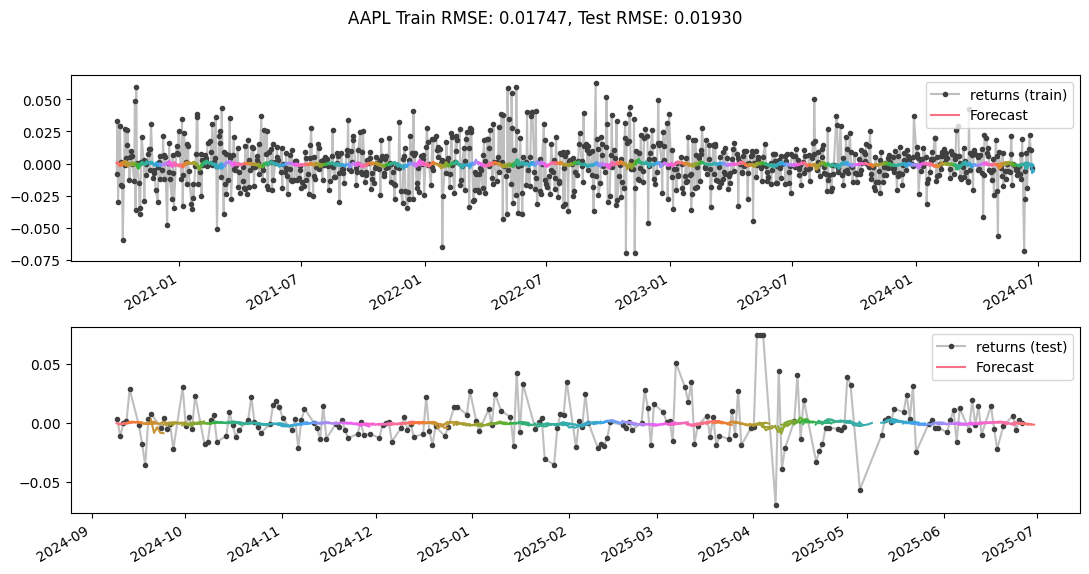

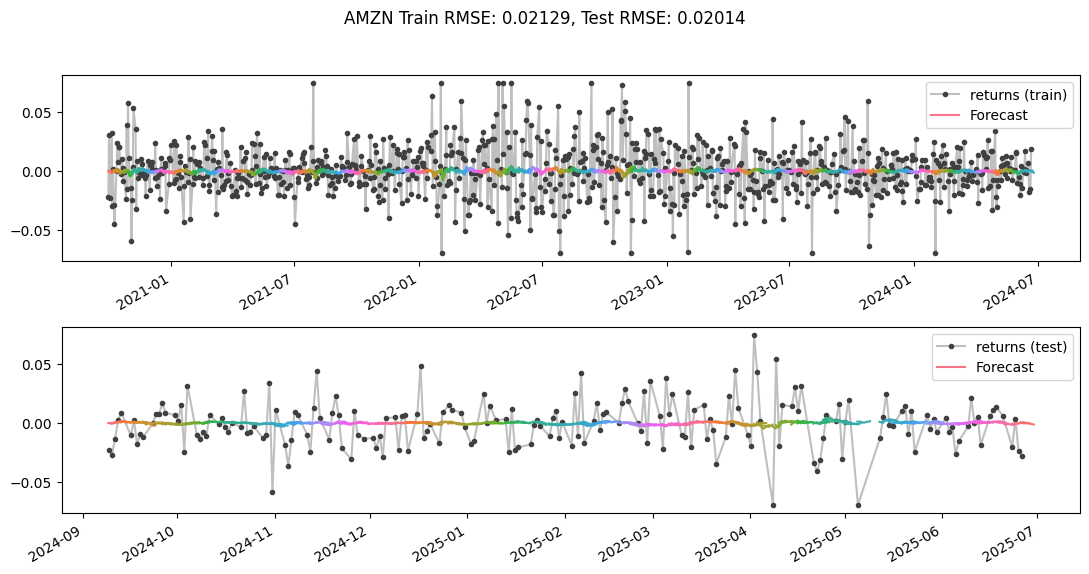

In [8]:
# Evaluate
for ticker in sample_tickers:
    evaluate_multistep_forecast(
        y_train.loc[ticker],
        y_train_hat_df.loc[ticker],
        y_test.loc[ticker],
        y_test_hat_df.loc[ticker],
        df_indexed.loc[ticker],
        ticker,
        target
    )

## Optimizing an ElasticNet

In [9]:
best_pipeline, best_params = optimize_elasticnet_pipeline(
    X_train=X_train,
    y_train=y_train,
    features2scale=features2scale,
    cv_splits=4,
    n_iter=25
)

Best hyperparameters: OrderedDict([('model__alpha', 0.04369339947510315), ('model__l1_ratio', 0.7277257431773251)])


In [10]:
# Predict
y_train_hat = best_pipeline.predict(X_train)
y_test_hat  = best_pipeline.predict(X_test)
# index for visualisation
df_indexed = df.set_index(['Ticker', 'Date'])
y_train_hat_df = pd.DataFrame(y_train_hat, index=y_train.index, columns=y_train.columns)
y_test_hat_df = pd.DataFrame(y_test_hat, index=y_test.index, columns=y_test.columns)

In [11]:
train_rmse = root_mean_squared_error(y_train, y_train_hat)
test_rmse = root_mean_squared_error(y_test, y_test_hat)
print((f"Train RMSE: {train_rmse:.5f}\n" f"Test RMSE: {test_rmse:.5f}"))

Train RMSE: 0.02317
Test RMSE: 0.02279


AAPL: Train RMSE: 0.01747, Test RMSE: 0.01922
AMZN: Train RMSE: 0.02128, Test RMSE: 0.02010


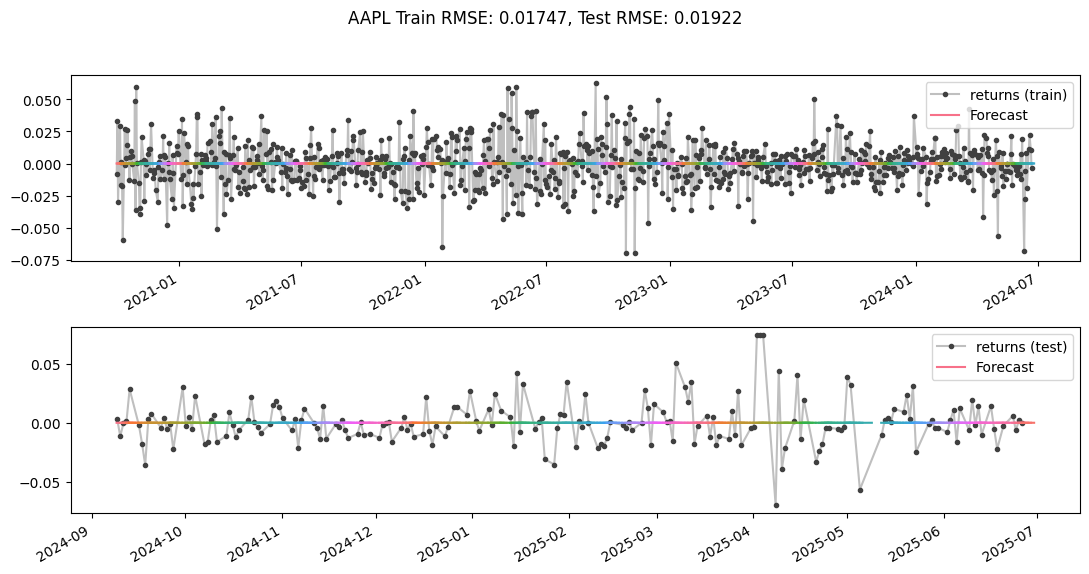

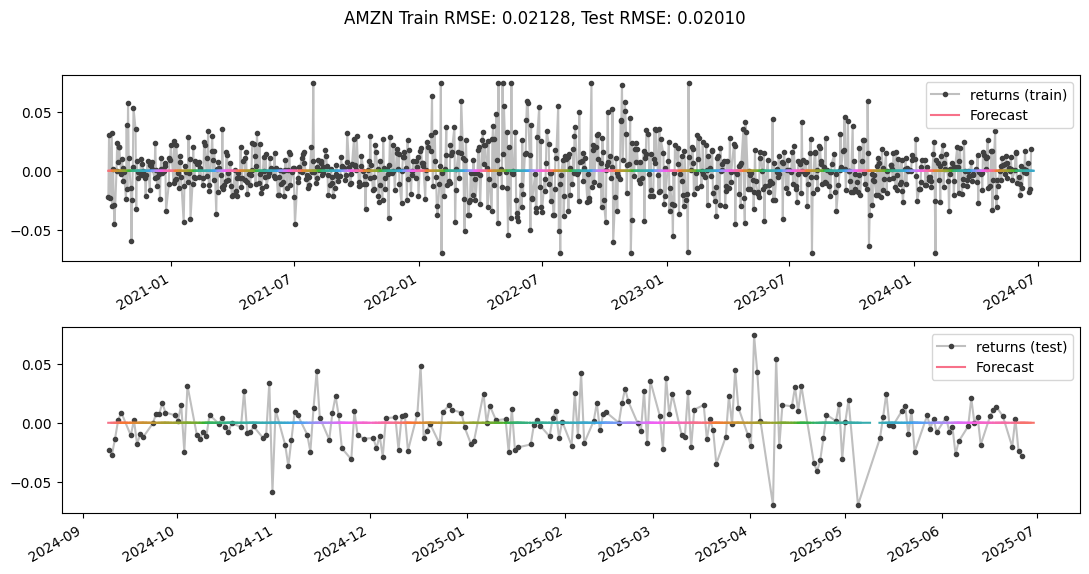

In [12]:
# Evaluate
for ticker in sample_tickers:
    evaluate_multistep_forecast(
        y_train.loc[ticker],
        y_train_hat_df.loc[ticker],
        y_test.loc[ticker],
        y_test_hat_df.loc[ticker],
        df_indexed.loc[ticker],
        ticker,
        target
    )